In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import gc
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor
from sklearn.preprocessing import KBinsDiscretizer

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.preprocessing import KBinsDiscretizer
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [23]:
TEST_PATH = r'D:\backup\my_ds_python\test.csv'
TRAIN_PATH = r'D:\backup\my_ds_python\train.csv'

df = pd.read_csv(TRAIN_PATH)

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv(TEST_PATH)

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect() 




Строк в трейне: 10000
Строк в тесте 5000


46

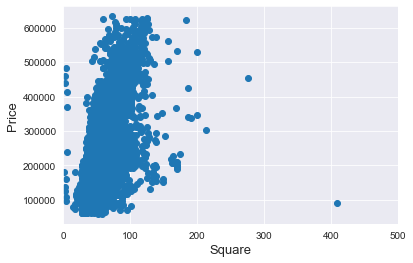

In [24]:
fig, ax = plt.subplots()
ax.scatter(x = X['Square'], y = y['Price'])
plt.xlabel('Square', fontsize=13)
plt.ylabel('Price', fontsize=13)
plt.xlim(0,500)
plt.show()

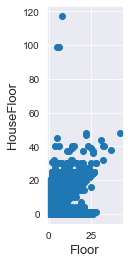

In [25]:
fig, ax = plt.subplots()
ax.scatter(x = X['Floor'], y = X['HouseFloor'])
plt.xlabel('Floor', fontsize=13)
plt.ylabel('HouseFloor', fontsize=13)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

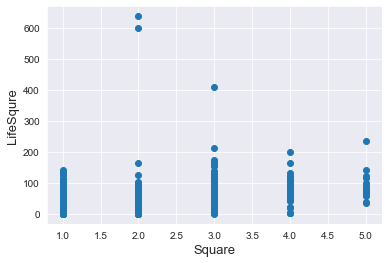

In [43]:
fig, ax = plt.subplots()
ax.scatter(x = X['Rooms'], y = X['LifeSquare'])
plt.xlabel('Rooms', fontsize=13)
plt.ylabel('LifeSqure', fontsize=13)


plt.show()


In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = X['Square'], y = X['LifeSquare'])
plt.xlabel('Square', fontsize=13)
plt.ylabel('LifeSqure', fontsize=13)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

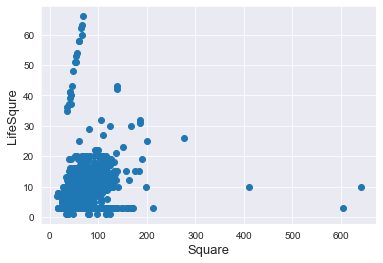

In [45]:
fig, ax = plt.subplots()
ax.scatter(x = X['Square'], y = X['KitchenSquare'])
plt.xlabel('Square', fontsize=13)
plt.ylabel('KitchenSquare', fontsize=13)

plt.show()

In [27]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [28]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        self.mode=None
        
    def fit(self, X):
        self.medians = X.median()
        self.mode = X.mode()
        self.current_year = datetime.datetime.now().year
        self.date_by_district_med = X.groupby(['DistrictId'])[['HouseYear']].median()
 
    
    def transform(self, X):
        
      
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        # 5 9 12 17 are the most common HouseFloors in Moscow so i changed outliers to them
        X.loc[(X['Floor'] > X['HouseFloor']) & (X['HouseFloor'] <= 5), 'HouseFloor'] = 5
        X.loc[(X['Floor'] > X['HouseFloor']) & ((X['HouseFloor'] <= 9 ) & ( X['HouseFloor'] > 5)), 'HouseFloor'] = 9
        X.loc[(X['Floor'] > X['HouseFloor']) & ((X['HouseFloor'] <= 12 ) & ( X['HouseFloor'] > 9)), 'HouseFloor'] = 12
        X.loc[(X['Floor'] > X['HouseFloor']) & (X['HouseFloor'] > 12), 'HouseFloor'] = 17
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        #------------------------
        #SquareOutliers
        X['LifeSquare_outlier'] = 0
        X['Square_outlier'] = 0
        
        X.loc[X['LifeSquare'] > 5000, 'LifeSquare_outlier'] = 1
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare_outlier'] = 1
        X.loc[X['Square'] < 10, 'Square_outlier'] = 1
        
        
        X.loc[X['LifeSquare'] > 5000, 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] =  X.loc[X['LifeSquare'] > X['Square'], 'Square']
        X.loc[X['Square'] < 10, 'Square'] = self.medians['Square']
        
        #Rooms
        X.loc[(X['Rooms'] < 1) & (X['LifeSquare'] < 30), 'Rooms'] = 1
        X.loc[(X['Rooms'] < 1) & (X['LifeSquare'] > 30) & (X['LifeSquare'] < 55), 'Rooms'] = 2
        X.loc[(X['Rooms'] < 1) & (X['LifeSquare'] > 55) & (X['LifeSquare'] < 85), 'Rooms'] = 3
        X.loc[(X['Rooms'] < 1) & (X['LifeSquare'] > 85) & (X['LifeSquare'] < 100), 'Rooms'] = 4
        X.loc[(X['Rooms'] < 1) & (X['LifeSquare'] > 100), 'Rooms'] = 5
        X.loc[(X['Rooms'] == 1) & (X['LifeSquare'] > 150), 'Rooms'] = 3
        X.loc[(X['Rooms'] > 10), 'Rooms'] = self.mode['Rooms'][0]
        
        #Kitchen
        X.loc[(X['KitchenSquare'] > 70) |(X['KitchenSquare'] < 3), 'KitchenSquare'] = self.mode['KitchenSquare'][0]
        
        for i in self.date_by_district_med.index:
            X.loc[(X['HouseYear'] > self.current_year) & (X['DistrictId'] == i), 'HouseYear'] = self.date_by_district_med.loc[i, 'HouseYear']
        
        return X
    

In [29]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)
                            

In [30]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_square_price_by_district = None
        self.med_price_by_house_year = None
        self.med_square_price_by_ecology_1 = None
        self.med_square_price_by_social_1 = None
    
    
    
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        ## median square depends on district
        if y is not None:
            df['Price'] = y.values
            df['Price_med'] = df['Price'] / df['Square'] 
            
            self.med_square_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price_med':'median'})\
                                                            .rename(columns={'Price_med':'med_square_price_by_district'})
            
        ## median square price depends on house year
        if y is not None:
            df['Price'] = y.values
            df['Price_med'] = df['Price'] / df['Square']
            self.med_price_by_house_year = df.groupby(['HouseYear'], as_index=False).agg({'Price_med':'median'})\
                                                            .rename(columns={'Price_med':'med_price_by_house_year'})
            
            ## median square price depends on Ecology_1
        if y is not None:
            df['Price'] = y.values
            df['Price_med'] = df['Price'] / df['Square'] 
            
            self.med_square_price_by_ecology_1 = df.groupby(['Ecology_1'], as_index=False).agg({'Price_med':'median'})\
                                                            .rename(columns={'Price_med':'med_square_price_by_ecology_1'})
        ## median square price depends on Social_1
        if y is not None:
            df['Price'] = y.values
            df['Price_med'] = df['Price'] / df['Square'] 
            
            self.med_square_price_by_social_1 = df.groupby(['Social_1'], as_index=False).agg({'Price_med':'median'})\
                                                            .rename(columns={'Price_med':'med_square_price_by_social_1'})
            
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
        
        
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_square_price_by_district is not None:
            X = X.merge(self.med_square_price_by_district, on=['DistrictId'], how='left')
        if self.med_price_by_house_year is not None:
            X = X.merge(self.med_price_by_house_year, on=['HouseYear'], how='left')
        if self.med_square_price_by_ecology_1 is not None:
            X = X.merge(self.med_square_price_by_ecology_1, on=['Ecology_1'], how='left')
        if self.med_square_price_by_social_1 is not None:
            X = X.merge(self.med_square_price_by_social_1, on=['Social_1'], how='left')
        
        
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            
    

In [31]:

features = FeatureGenerator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)



In [32]:
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
       'LifeSquare_nan', 'LifeSquare_outlier', 'Square_outlier',
       'DistrictId_count', 'new_district', 'floor_cat', 'year_cat',
       'MedPriceByDistrict', 'MedPriceByFloorYear',
       'med_square_price_by_district', 'med_price_by_house_year',
       'med_square_price_by_ecology_1', 'med_square_price_by_social_1'],
      dtype='object')

In [33]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear','LifeSquare_outlier', 'Square_outlier',
                   'MedPriceByDistrict', 'MedPriceByFloorYear',
                  'DistrictId_count', 'new_district', 
                  
                   'med_square_price_by_district', 'med_price_by_house_year','med_square_price_by_ecology_1',
                   'med_square_price_by_social_1', 'DistrictId']

X = X[remain_features]
X_final = X_final[remain_features]


In [34]:
#parameters = [{'max_depth': np.arange(2,5), 'min_samples_leaf': np.arange(5, 8), 'n_estimators': np.arange(150, 201, 10)}]
#gs = GridSearchCV(estimator=LGBMRegressor(random_state=42), param_grid=parameters, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
#gs.fit(X, y)
#gs.best_params_

In [35]:
model1 = LGBMRegressor(max_depth=4,
                             min_samples_leaf=5,
                             n_estimators=180,
                             random_state=42)


model2 = CatBoostRegressor(cat_features = ['DistrictId'])
model = VotingRegressor([('model1', model1), ('model2', model2)])
score = cross_val_score(model, X, y, cv=5)


R2: 0.757 +- 0.021
Learning rate set to 0.056513
0:	learn: 89609.3929610	total: 86.6ms	remaining: 1m 26s
1:	learn: 86650.7301901	total: 110ms	remaining: 55s
2:	learn: 84033.4605602	total: 132ms	remaining: 43.9s
3:	learn: 81423.0492076	total: 188ms	remaining: 46.8s
4:	learn: 78868.9684909	total: 234ms	remaining: 46.6s
5:	learn: 76527.7152233	total: 271ms	remaining: 44.9s
6:	learn: 74351.2379966	total: 326ms	remaining: 46.3s
7:	learn: 72342.2182628	total: 366ms	remaining: 45.4s
8:	learn: 70516.9358827	total: 405ms	remaining: 44.6s
9:	learn: 68856.0505064	total: 436ms	remaining: 43.2s
10:	learn: 67341.6580907	total: 464ms	remaining: 41.7s
11:	learn: 65888.2085152	total: 491ms	remaining: 40.5s
12:	learn: 64426.2736348	total: 516ms	remaining: 39.2s
13:	learn: 63133.1979841	total: 535ms	remaining: 37.7s
14:	learn: 61982.3277289	total: 557ms	remaining: 36.6s
15:	learn: 60910.3939648	total: 582ms	remaining: 35.8s
16:	learn: 59890.1930662	total: 616ms	remaining: 35.6s
17:	learn: 58901.5525924	t

In [36]:
# Обучаю модель на всем трейне
model.fit(X, y)


Learning rate set to 0.058803
0:	learn: 89455.1695095	total: 19.5ms	remaining: 19.4s
1:	learn: 86206.8605829	total: 39.3ms	remaining: 19.6s
2:	learn: 83234.7983396	total: 54.8ms	remaining: 18.2s
3:	learn: 80534.9555532	total: 73.6ms	remaining: 18.3s
4:	learn: 78260.3101922	total: 105ms	remaining: 21s
5:	learn: 75892.5965010	total: 165ms	remaining: 27.3s
6:	learn: 73733.6490037	total: 187ms	remaining: 26.5s
7:	learn: 71688.5427569	total: 208ms	remaining: 25.8s
8:	learn: 69847.3254391	total: 230ms	remaining: 25.3s
9:	learn: 68108.8977256	total: 267ms	remaining: 26.4s
10:	learn: 66496.4791903	total: 292ms	remaining: 26.3s
11:	learn: 65049.7969775	total: 315ms	remaining: 25.9s
12:	learn: 63603.6722524	total: 333ms	remaining: 25.3s
13:	learn: 62330.9396192	total: 361ms	remaining: 25.4s
14:	learn: 61182.7657059	total: 383ms	remaining: 25.1s
15:	learn: 60065.2901638	total: 440ms	remaining: 27.1s
16:	learn: 59070.3176921	total: 468ms	remaining: 27.1s
17:	learn: 58025.2783457	total: 490ms	remai

VotingRegressor(estimators=[('model1',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=4,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_samples_leaf=5,
                                           min_split_gain=0.0, n_estimators=180,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=42,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsample=1.0,
                                           subsample_for_bin

In [41]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,160400.657
1,15856,216116.217
2,5480,190939.483
3,15664,320438.865
4,14275,141416.567


In [ ]:
preds_final.shape